# MODELOS DE REDES PARA DENGUE BUCARAMANGA

### Cargue de librerias requeridas

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import IPython
import IPython.display
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Input, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from scipy.stats import randint as sp_randint
np.random.seed(123) # for reproducibility
import warnings
warnings.filterwarnings('ignore')

### Cargar la base de datos

In [2]:
datos = read_csv('Bucaramanga_Lags.csv', encoding='latin-1', sep=";")
datos.columns

Index(['Municipio', 'Año', 'Semana_Epi', 'Casos_Dengue', 'Prom_Dia_Preci',
       'Prom_Dia_Preci_1', 'Prom_Dia_Preci_2', 'Prom_Dia_Preci_3',
       'Prom_Dia_Preci_4', 'Prom_Dia_Preci_5', 'Prom_Dia_Preci_6',
       'Total_Preci_Sem', 'Total_Preci_Sem_1', 'Total_Preci_Sem_2',
       'Total_Preci_Sem_3', 'Total_Preci_Sem_4', 'Total_Preci_Sem_5',
       'Total_Preci_Sem_6'],
      dtype='object')

In [3]:
# Se eliminan las columnas de las variables que No se van a utilizar
datos = datos.drop(['Municipio', 'Año', 'Semana_Epi','Prom_Dia_Preci','Prom_Dia_Preci_6',
                    'Prom_Dia_Preci_2', 'Prom_Dia_Preci_3', 'Prom_Dia_Preci_4', 'Prom_Dia_Preci_5',
                    'Total_Preci_Sem', 'Total_Preci_Sem_6', 'Total_Preci_Sem_2',
                    'Total_Preci_Sem_3', 'Total_Preci_Sem_4', 'Total_Preci_Sem_5'],axis=1)

datos.columns

Index(['Casos_Dengue', 'Prom_Dia_Preci_1', 'Total_Preci_Sem_1'], dtype='object')

In [4]:
#Se verifican datos nulos o faltantes
datos.isnull().sum()

Casos_Dengue         0
Prom_Dia_Preci_1     0
Total_Preci_Sem_1    0
dtype: int64

### División de los datos en set de entrenamiento y prueba

In [5]:
train_size = int(len(datos) * 0.7)
test_size = len(datos) - train_size
train, test = datos.iloc[0:train_size], datos.iloc[train_size:len(datos)]
print(len(train), len(test))

436 188


In [6]:
f_columns = ['Prom_Dia_Preci_1', 'Total_Preci_Sem_1']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [7]:
dengue_transformer = MinMaxScaler(feature_range=(0, 1))
dengue_transformer = dengue_transformer.fit(train[['Casos_Dengue']])
train['Casos_Dengue'] = dengue_transformer.transform(train[['Casos_Dengue']])
test['Casos_Dengue'] = dengue_transformer.transform(test[['Casos_Dengue']])

In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# MODELO LSTM

In [9]:
# Creación de X_train, y_train, X_test y y_test Para el modelo LSTM

time_steps = 10

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_LSTM, y_train_LSTM = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_LSTM, y_test_LSTM = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_LSTM.shape, y_train_LSTM.shape, X_test_LSTM.shape, y_test_LSTM.shape )

(426, 10, 3) (426,) (178, 10, 3) (178,)


### Construcción, Compilación y entrenamiento del modelo LSTM

In [10]:
Buca_LSTM_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Buca_LSTM_model_2.add(keras.layers.InputLayer(input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    
    
#CAPAS INTERMEDIAS

Buca_LSTM_model_2.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Buca_LSTM_model_2.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Buca_LSTM_model_2.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Buca_LSTM_model_2.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Buca_LSTM_model_2.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Buca_LSTM_model_2.h5'
checkpoint_LSTM = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_LSTM = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_LSTM = Buca_LSTM_model_2.fit(X_train_LSTM,y_train_LSTM, validation_data=(X_test_LSTM,y_test_LSTM), 
                                     verbose=2, epochs=100, callbacks=[monitor_LSTM, checkpoint_LSTM])
Buca_LSTM_model_2.load_weights(model_filepath)

Epoch 1/100
14/14 - 12s - loss: 0.0384 - mse: 0.0384 - val_loss: 0.0124 - val_mse: 0.0124 - 12s/epoch - 846ms/step
Epoch 2/100
14/14 - 1s - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0029 - val_mse: 0.0029 - 599ms/epoch - 43ms/step
Epoch 3/100
14/14 - 1s - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0077 - val_mse: 0.0077 - 520ms/epoch - 37ms/step
Epoch 4/100
14/14 - 1s - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0073 - val_mse: 0.0073 - 518ms/epoch - 37ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0055 - val_mse: 0.0055 - 498ms/epoch - 36ms/step
Epoch 6/100
14/14 - 1s - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0043 - val_mse: 0.0043 - 556ms/epoch - 40ms/step
Epoch 7/100
14/14 - 1s - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0067 - val_mse: 0.0067 - 511ms/epoch - 37ms/step


# MODELO CNN

In [11]:
# Creación de X_train, y_train, X_test y y_test Para el modelo CNN

time_steps = 10

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_CNN, y_train_CNN = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_CNN, y_test_CNN = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_CNN.shape, y_train_CNN.shape, X_test_CNN.shape, y_test_CNN.shape )

(426, 10, 3) (426,) (178, 10, 3) (178,)


### Construcción, Compilación y entrenamiento del modelo CNN

In [12]:
Buca_CNN_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Buca_CNN_model_2.add(keras.layers.InputLayer(input_shape=(X_train_CNN.shape[1], X_train_CNN.shape[2])))
    
    
#CAPAS INTERMEDIAS

Buca_CNN_model_2.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Buca_CNN_model_2.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Buca_CNN_model_2.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Buca_CNN_model_2.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Buca_CNN_model_2.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Buca_CNN_model_2.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Buca_CNN_model_2.add(Dropout(0.5))
Buca_CNN_model_2.add(Flatten())
    
Buca_CNN_model_2.add(keras.layers.Dense(units=256, activation='linear'))
Buca_CNN_model_2.add(Dropout(0.5)) 


#CAPA DE SALIDA                 
Buca_CNN_model_2.add(Dense(1))


#COMPILACIÓN DEL MODELO
Buca_CNN_model_2.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Buca_CNN_model_2.h5'
checkpoint_CNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_CNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_CNN = Buca_CNN_model_2.fit(X_train_CNN,y_train_CNN, validation_data=(X_test_CNN,y_test_CNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_CNN, checkpoint_CNN])
Buca_CNN_model_2.load_weights(model_filepath)

Epoch 1/100
14/14 - 1s - loss: 0.0249 - mse: 0.0249 - val_loss: 0.0015 - val_mse: 0.0015 - 1s/epoch - 95ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0012 - val_mse: 0.0012 - 153ms/epoch - 11ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0010 - val_mse: 0.0010 - 165ms/epoch - 12ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0021 - val_mse: 0.0021 - 122ms/epoch - 9ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0014 - val_mse: 0.0014 - 109ms/epoch - 8ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0046 - val_mse: 0.0046 - 137ms/epoch - 10ms/step


# MODELO RNN

In [13]:
# Creación de X_train, y_train, X_test y y_test Para el modelo RNN

time_steps = 10

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_RNN, y_train_RNN = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_RNN, y_test_RNN = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_RNN.shape, y_train_RNN.shape, X_test_RNN.shape, y_test_RNN.shape )

(426, 10, 3) (426,) (178, 10, 3) (178,)


### Construcción, Compilación y entrenamiento del modelo RNN

In [14]:
Buca_RNN_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Buca_RNN_model_2.add(keras.layers.InputLayer(input_shape=(X_train_RNN.shape[1], X_train_RNN.shape[2])))
    
    
#CAPAS INTERMEDIAS

Buca_RNN_model_2.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Buca_RNN_model_2.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Buca_RNN_model_2.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Buca_RNN_model_2.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Buca_RNN_model_2.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Buca_RNN_model_2.h5'
checkpoint_RNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_RNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_RNN = Buca_RNN_model_2.fit(X_train_RNN,y_train_RNN, validation_data=(X_test_RNN,y_test_RNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_RNN, checkpoint_RNN])
Buca_RNN_model_2.load_weights(model_filepath)

Epoch 1/100
14/14 - 4s - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0043 - val_mse: 0.0043 - 4s/epoch - 287ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0144 - val_mse: 0.0144 - 206ms/epoch - 15ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0034 - val_mse: 0.0034 - 246ms/epoch - 18ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0042 - val_mse: 0.0042 - 217ms/epoch - 16ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0032 - val_mse: 0.0032 - 247ms/epoch - 18ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0021 - val_mse: 0.0021 - 259ms/epoch - 18ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0029 - val_mse: 0.0029 - 189ms/epoch - 14ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0049 - val_mse: 0.0049 - 199ms/epoch - 14ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0056 - val_mse: 

# MODELO GRU

In [15]:
# Creación de X_train, y_train, X_test y y_test Para el modelo GRU

time_steps = 10

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_GRU, y_train_GRU = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_GRU, y_test_GRU = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_GRU.shape, y_train_GRU.shape, X_test_GRU.shape, y_test_GRU.shape )

(426, 10, 3) (426,) (178, 10, 3) (178,)


### Construcción, Compilación y entrenamiento del modelo GRU

In [16]:
Buca_GRU_model_2 = keras.Sequential()
    
# CAPA DE ENTRADA
Buca_GRU_model_2.add(keras.layers.InputLayer(input_shape=(X_train_GRU.shape[1], X_train_GRU.shape[2])))
    
    
#CAPAS INTERMEDIAS

Buca_GRU_model_2.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Buca_GRU_model_2.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Buca_GRU_model_2.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Buca_GRU_model_2.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Buca_GRU_model_2.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Buca_GRU_model_2.h5'
checkpoint_GRU = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_GRU = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_GRU = Buca_GRU_model_2.fit(X_train_GRU,y_train_GRU, validation_data=(X_test_GRU,y_test_GRU), 
                                     verbose=2, epochs=100, callbacks=[monitor_GRU, checkpoint_GRU])
Buca_GRU_model_2.load_weights(model_filepath)

Epoch 1/100
14/14 - 10s - loss: 0.0382 - mse: 0.0382 - val_loss: 0.0061 - val_mse: 0.0061 - 10s/epoch - 704ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0067 - val_mse: 0.0067 - 458ms/epoch - 33ms/step
Epoch 3/100
14/14 - 1s - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0072 - val_mse: 0.0072 - 699ms/epoch - 50ms/step
Epoch 4/100
14/14 - 1s - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0031 - val_mse: 0.0031 - 549ms/epoch - 39ms/step
Epoch 5/100
14/14 - 1s - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0030 - val_mse: 0.0030 - 539ms/epoch - 38ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0037 - val_mse: 0.0037 - 495ms/epoch - 35ms/step
Epoch 7/100
14/14 - 1s - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0029 - val_mse: 0.0029 - 601ms/epoch - 43ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0035 - val_mse: 0.0035 - 488ms/epoch - 35ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0068 - val_mse

### Graficas de función de pérdida & RMSE

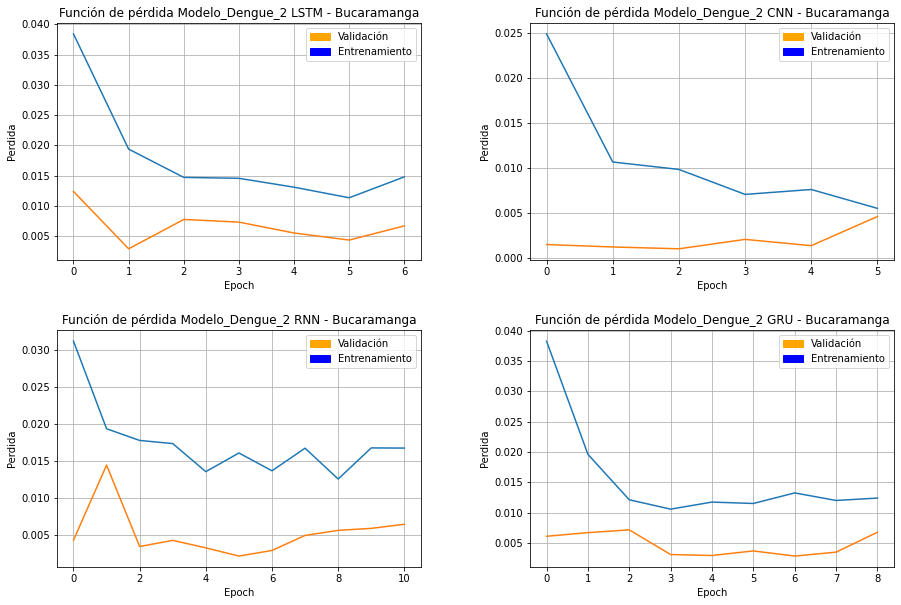

In [17]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_2 LSTM - Bucaramanga')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])

plt.subplot(2, 2, 2)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_2 CNN - Bucaramanga')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])

plt.subplot(2, 2, 3)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_2 RNN - Bucaramanga')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])

plt.subplot(2, 2, 4)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_2 GRU - Bucaramanga')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])

plt.show()

# Gráficas de dispersión

6/6 [==============================] - 1s 14ms/step


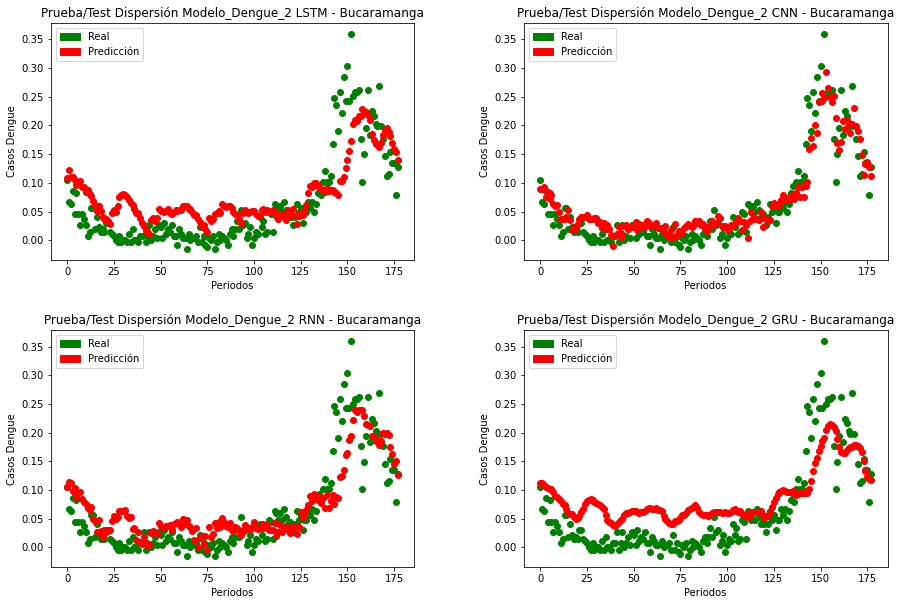

In [18]:
results_LSTM =Buca_LSTM_model_2.predict(X_test_LSTM)
results_CNN =Buca_CNN_model_2.predict(X_test_CNN)
results_RNN =Buca_RNN_model_2.predict(X_test_RNN)
results_GRU =Buca_GRU_model_2.predict(X_test_GRU)

plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_2 LSTM - Bucaramanga')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_LSTM)),y_test_LSTM,c='g')
plt.scatter(range(len(results_LSTM)),results_LSTM,c='r')

plt.subplot(2, 2, 2)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_2 CNN - Bucaramanga')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_CNN)),y_test_CNN,c='g')
plt.scatter(range(len(results_CNN)),results_CNN,c='r')

plt.subplot(2, 2, 3)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_2 RNN - Bucaramanga')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_RNN)),y_test_RNN,c='g')
plt.scatter(range(len(results_RNN)),results_RNN,c='r')

plt.subplot(2, 2, 4)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_2 GRU - Bucaramanga')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_GRU)),y_test_GRU,c='g')
plt.scatter(range(len(results_GRU)),results_GRU,c='r')

plt.show()

In [19]:
y_pred_LSTM = Buca_LSTM_model_2.predict(X_test_LSTM)
y_pred_CNN = Buca_CNN_model_2.predict(X_test_CNN)
y_pred_RNN = Buca_RNN_model_2.predict(X_test_RNN)
y_pred_GRU = Buca_GRU_model_2.predict(X_test_GRU)

y_train_inv_LSTM = dengue_transformer.inverse_transform(y_train_LSTM.reshape(1, -1))
y_train_inv_CNN = dengue_transformer.inverse_transform(y_train_CNN.reshape(1, -1))
y_train_inv_RNN = dengue_transformer.inverse_transform(y_train_RNN.reshape(1, -1))
y_train_inv_GRU = dengue_transformer.inverse_transform(y_train_GRU.reshape(1, -1))

y_test_inv_LSTM = dengue_transformer.inverse_transform(y_test_LSTM.reshape(1, -1))
y_test_inv_CNN = dengue_transformer.inverse_transform(y_test_CNN.reshape(1, -1))
y_test_inv_RNN = dengue_transformer.inverse_transform(y_test_RNN.reshape(1, -1))
y_test_inv_GRU = dengue_transformer.inverse_transform(y_test_GRU.reshape(1, -1))

y_pred_inv_LSTM = dengue_transformer.inverse_transform(y_pred_LSTM)
y_pred_inv_CNN = dengue_transformer.inverse_transform(y_pred_CNN)
y_pred_inv_RNN = dengue_transformer.inverse_transform(y_pred_RNN)
y_pred_inv_GRU = dengue_transformer.inverse_transform(y_pred_GRU)

6/6 [==============================] - 0s 11ms/step


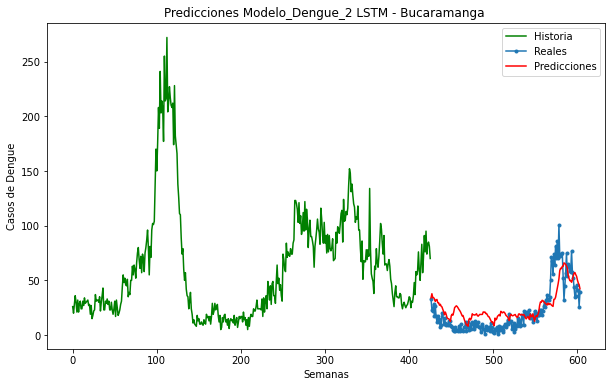

In [20]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_LSTM)), y_train_inv_LSTM.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_test_inv_LSTM.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_pred_inv_LSTM.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_2 LSTM - Bucaramanga ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

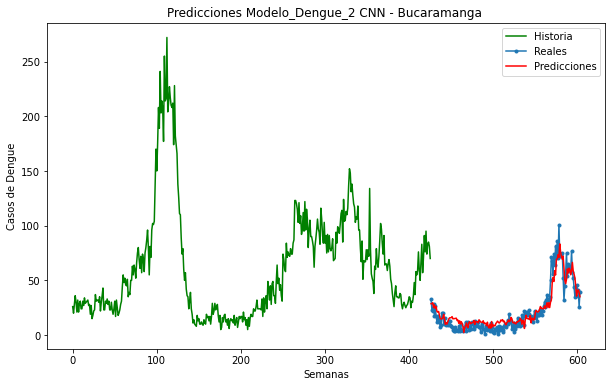

In [21]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_CNN)), y_train_inv_CNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_test_inv_CNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_pred_inv_CNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_2 CNN - Bucaramanga ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

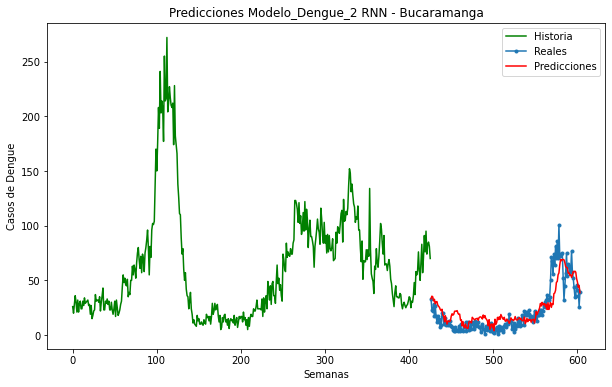

In [22]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_RNN)), y_train_inv_RNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_test_inv_RNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_pred_inv_RNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_2 RNN - Bucaramanga')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

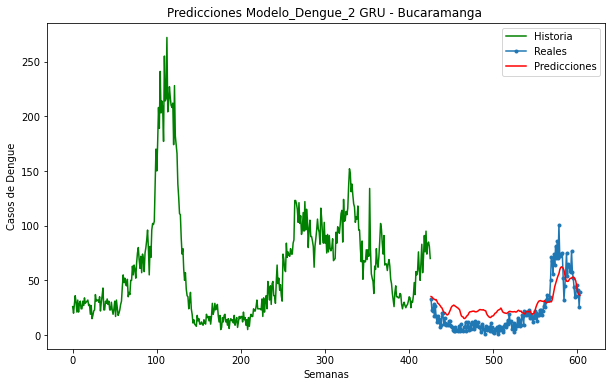

In [23]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_GRU)), y_train_inv_GRU.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_test_inv_GRU.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_pred_inv_GRU.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_2 GRU - Bucaramanga ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

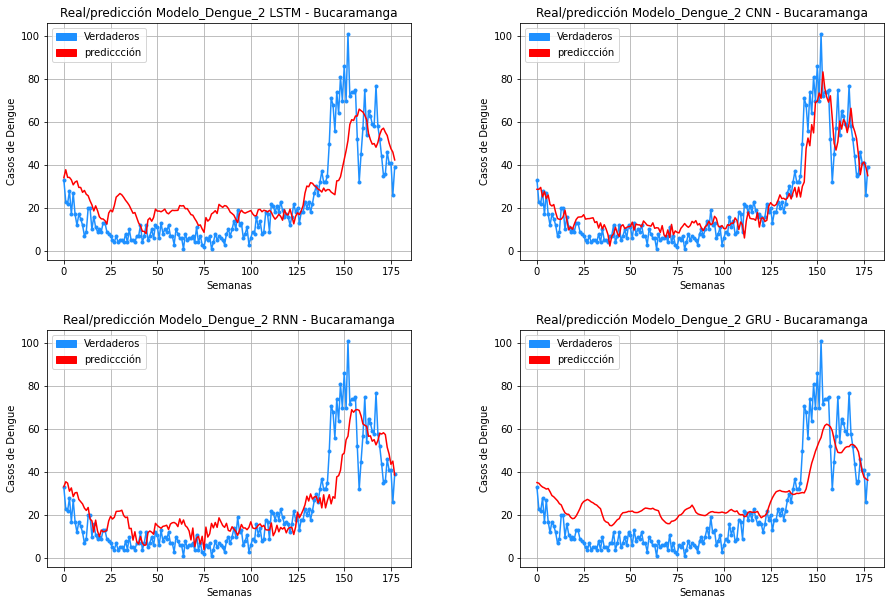

In [24]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
plt.title('Real/predicción Modelo_Dengue_2 LSTM - Bucaramanga' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_LSTM.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_LSTM.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Real/predicción Modelo_Dengue_2 CNN - Bucaramanga' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_CNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_CNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Real/predicción Modelo_Dengue_2 RNN - Bucaramanga' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_RNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_RNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('Real/predicción Modelo_Dengue_2 GRU - Bucaramanga' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_GRU.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_GRU.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.show()

In [25]:
score_LSTM = np.sqrt(metrics.mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
score_CNN = np.sqrt(metrics.mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
score_RNN = np.sqrt(metrics.mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
score_GRU = np.sqrt(metrics.mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

print("RMSE Modelo_2 LSTM Dengue Bucaramanga : {}".format(score_LSTM))
print("RMSE Modelo_2  CNN Dengue  Bucaramanga  : {}".format(score_CNN))
print("RMSE Modelo_2  RNN Dengue  Bucaramanga : {}".format(score_RNN))
print("RMSE Modelo_2  GRU Dengue  Bucaramanga  : {}".format(score_GRU))

RMSE Modelo_2 LSTM Dengue Bucaramanga : 14.378082484554803
RMSE Modelo_2  CNN Dengue  Bucaramanga  : 8.614561048614123
RMSE Modelo_2  RNN Dengue  Bucaramanga : 12.282332366272847
RMSE Modelo_2  GRU Dengue  Bucaramanga  : 14.343460245108723


In [26]:
print("MSE Modelo_2  LSTM Dengue Bucaramanga  = ", mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MSE Modelo_2  CNN Dengue Bucaramanga   = ", mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MSE Modelo_2  RNN Dengue Bucaramanga   = ", mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MSE Modelo_2  GRU Dengue Bucaramanga   = ", mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MSE Modelo_2  LSTM Dengue Bucaramanga  =  206.7292559326616
MSE Modelo_2  CNN Dengue Bucaramanga   =  74.21066206029965
MSE Modelo_2  RNN Dengue Bucaramanga   =  150.85568835559354
MSE Modelo_2  GRU Dengue Bucaramanga   =  205.73485180301438


In [27]:
print("MAE Modelo_2  LSTM Dengue Bucaramanga = ", mean_absolute_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MAE Modelo_2  CNN Dengue Bucaramanga  = ", mean_absolute_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MAE Modelo_2  RNN Dengue Bucaramanga  = ", mean_absolute_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MAE Modelo_2  GRU Dengue Bucaramanga = ", mean_absolute_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MAE Modelo_2  LSTM Dengue Bucaramanga =  11.227946967221378
MAE Modelo_2  CNN Dengue Bucaramanga  =  6.282465281111471
MAE Modelo_2  RNN Dengue Bucaramanga  =  8.889254211040026
MAE Modelo_2  GRU Dengue Bucaramanga =  12.215071056666


In [28]:
print("r2_score Modelo_2  LSTM Dengue Bucaramanga  = ", r2_score(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("r2_score Modelo_2  CNN Dengue Bucaramanga = ", r2_score(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("r2_score Modelo_2  RNN Dengue Bucaramanga  = ", r2_score(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("r2_score Modelo_2  GRU Dengue Bucaramanga  = ", r2_score(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

r2_score Modelo_2  LSTM Dengue Bucaramanga  =  0.5555129112130252
r2_score Modelo_2  CNN Dengue Bucaramanga =  0.8404401883646255
r2_score Modelo_2  RNN Dengue Bucaramanga  =  0.6756462676672412
r2_score Modelo_2  GRU Dengue Bucaramanga  =  0.5576509723919838


In [29]:
print("explained_variance_score Modelo_2  LSTM Dengue Bucaramanga  = ", explained_variance_score(y_test_inv_LSTM.flatten(), 
                                                                                           y_pred_inv_LSTM.flatten()))
print("explained_variance_score Modelo_2  CNN Dengue Bucaramanga  = ", explained_variance_score(y_test_inv_CNN.flatten(), 
                                                                                           y_pred_inv_CNN.flatten()))
print("explained_variance_score Modelo_2  RNN Dengue Bucaramanga  = ", explained_variance_score(y_test_inv_RNN.flatten(), 
                                                                                           y_pred_inv_RNN.flatten()))
print("explained_variance_score Modelo_2  GRU Dengue Bucaramanga  = ", explained_variance_score(y_test_inv_GRU.flatten(), 
                                                                                           y_test_inv_GRU.flatten()))

explained_variance_score Modelo_2  LSTM Dengue Bucaramanga  =  0.594196437182405
explained_variance_score Modelo_2  CNN Dengue Bucaramanga  =  0.8439295811648223
explained_variance_score Modelo_2  RNN Dengue Bucaramanga  =  0.6867380564351249
explained_variance_score Modelo_2  GRU Dengue Bucaramanga  =  1.0


### VISUALIZACIÓN DE LOS VALORES TESTEADOS VS LAS PREDICCIONES

In [30]:
#MODELO LSTM
resultados_LSTM = pd.DataFrame({ 'Actuales':y_test_inv_LSTM.flatten(), 'Predicciones': y_pred_inv_LSTM.flatten()})
resultados_LSTM['diferencia'] = resultados_LSTM['Predicciones'] - resultados_LSTM['Actuales']
print(resultados_LSTM.head(5))
print(resultados_LSTM.tail(5))

   Actuales  Predicciones  diferencia
0      33.0     34.074379    1.074379
1      23.0     37.796677   14.796677
2      22.0     34.257912   12.257912
3      28.0     34.227081    6.227081
4      17.0     33.111736   16.111736
     Actuales  Predicciones  diferencia
173      46.0     53.724892    7.724892
174      41.0     50.230888    9.230888
175      41.0     47.586998    6.586998
176      26.0     46.013416   20.013416
177      39.0     42.370346    3.370346


In [31]:
#MODELO CNN
resultados_CNN = pd.DataFrame({ 'Actuales':y_test_inv_CNN.flatten(), 'Predicciones': y_pred_inv_CNN.flatten()})
resultados_CNN['diferencia'] = resultados_CNN['Predicciones'] - resultados_CNN['Actuales']
print(resultados_CNN.head(5))
print(resultados_CNN.tail(5))

   Actuales  Predicciones  diferencia
0      33.0     28.690512   -4.309488
1      23.0     28.676411    5.676411
2      22.0     29.569481    7.569481
3      28.0     25.174942   -2.825058
4      17.0     27.602867   10.602867
     Actuales  Predicciones  diferencia
173      46.0     35.559956  -10.440044
174      41.0     40.561821   -0.438179
175      41.0     41.404568    0.404568
176      26.0     38.869907   12.869907
177      39.0     35.052891   -3.947109


In [32]:
#MODELO RNN
resultados_RNN = pd.DataFrame({ 'Actuales':y_test_inv_RNN.flatten(), 'Predicciones': y_pred_inv_RNN.flatten()})
resultados_RNN['diferencia'] = resultados_RNN['Predicciones'] - resultados_RNN['Actuales']
print(resultados_RNN.head(5))
print(resultados_RNN.tail(5))

   Actuales  Predicciones  diferencia
0      33.0     33.277096    0.277096
1      23.0     35.569466   12.569466
2      22.0     34.941902   12.941902
3      28.0     31.192585    3.192585
4      17.0     32.711437   15.711437
     Actuales  Predicciones  diferencia
173      46.0     51.624138    5.624138
174      41.0     48.483398    7.483398
175      41.0     43.697384    2.697384
176      26.0     45.190590   19.190590
177      39.0     38.706612   -0.293388


In [33]:
#MODELO GRU
resultados_GRU = pd.DataFrame({ 'Actuales':y_test_inv_GRU.flatten(), 'Predicciones': y_pred_inv_GRU.flatten()})
resultados_GRU['diferencia'] = resultados_GRU['Predicciones'] - resultados_GRU['Actuales']
print(resultados_GRU.head(5))
print(resultados_GRU.tail(5))

   Actuales  Predicciones  diferencia
0      33.0     35.196129    2.196129
1      23.0     34.904972   11.904972
2      22.0     33.856838   11.856838
3      28.0     33.119854    5.119854
4      17.0     32.728188   15.728188
     Actuales  Predicciones  diferencia
173      46.0     45.039436   -0.960564
174      41.0     40.417641   -0.582359
175      41.0     37.709465   -3.290535
176      26.0     36.910469   10.910469
177      39.0     36.315163   -2.684837
